# Euchre Trick Model
Model to estimate the number of tricks a given hand will be able to take  
(or maybe the percent likelihood of each number of tricks taken 0-5)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Load in training data

In [2]:
pwd

'/Users/jeremy/Desktop/nonsense/euchre/notebooks'

In [3]:
# TODO: move this from local to s3
raw_train_df = pd.read_csv('all_hand_results.csv')

In [4]:
raw_train_df.shape

(502256, 16)

In [5]:
raw_train_df.head()

,tricks_won,is_calling_player,teammate_called,has_right,has_left,has_Atrump,has_Ktrump,has_Qtrump,has_Ttrump,has_9trump,num_off_A,num_off_K,num_off_Q,num_suits,partner_tricks,player_seat
0,2,0,0,0,1,0,1,1,0,0,0,1,1,3,0,4
1,3,1,0,1,0,1,0,0,1,0,0,0,1,2,0,1
2,0,0,1,0,0,0,0,0,0,0,0,2,0,3,3,2
3,0,0,0,0,0,0,0,0,0,1,1,0,1,3,2,3
4,0,0,1,0,0,0,0,0,0,0,0,1,0,3,2,1


In [6]:
raw_train_df['tricks_won'].value_counts()

tricks_won
1    173815
0    147233
2    107815
3     56330
4     15930
5      1133
Name: count, dtype: int64

In [7]:
raw_train_df['num_suits'].value_counts()

num_suits
3    288739
4    135837
2     76910
1       770
Name: count, dtype: int64

#### Features

In [8]:
# create team_tricks_won
raw_train_df['team_tricks_won'] = raw_train_df['partner_tricks'] + raw_train_df['tricks_won']

In [9]:
def make_player_seat_categorical(df):
    """
    Function to transform player seat field into categorical columns from given df
    """
    df['player_seat1'] = np.where(df['player_seat']==1,1,0)
    df['player_seat2'] = np.where(df['player_seat']==2,1,0)
    df['player_seat3'] = np.where(df['player_seat']==3,1,0)
    df['player_seat4'] = np.where(df['player_seat']==4,1,0)
    return df

In [10]:
raw_train_df = make_player_seat_categorical(raw_train_df)

In [11]:
raw_train_df.head()

,tricks_won,is_calling_player,teammate_called,has_right,has_left,has_Atrump,has_Ktrump,has_Qtrump,has_Ttrump,has_9trump,...,num_off_K,num_off_Q,num_suits,partner_tricks,player_seat,team_tricks_won,player_seat1,player_seat2,player_seat3,player_seat4
0,2,0,0,0,1,0,1,1,0,0,...,1,1,3,0,4,2,0,0,0,1
1,3,1,0,1,0,1,0,0,1,0,...,0,1,2,0,1,3,1,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,2,0,3,3,2,3,0,1,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,1,3,2,3,2,0,0,1,0
4,0,0,1,0,0,0,0,0,0,0,...,1,0,3,2,1,2,1,0,0,0


### Create train/test/validation splits

In [12]:
model_features = ['has_right', 'has_left',
                  'has_Atrump', 'has_Ktrump', 'has_Qtrump', 'has_Ttrump', 'has_9trump', 
                  'num_off_A', 'num_off_K', 'num_off_Q', 'num_suits', 
                  'player_seat1', 'player_seat2', 'player_seat3', 'player_seat4'
                 ]

In [13]:
TEST_SIZE = 0.2
VALID_SIZE = 0.1

In [14]:
train_df, test_valid_df, train_targets_df, test_valid_targets_df = train_test_split(raw_train_df[model_features], 
                                                                        raw_train_df['tricks_won'], 
                                                                        test_size=(TEST_SIZE+VALID_SIZE), 
                                                                        random_state=123)

In [15]:
test_df, valid_df, test_targets_df, valid_targets_df = train_test_split(test_valid_df, 
                                                                        test_valid_targets_df, 
                                                                        test_size=(TEST_SIZE/(VALID_SIZE+TEST_SIZE)), 
                                                                        random_state=123)

In [16]:
print(test_df.shape)
print(test_targets_df.shape)
print(valid_df.shape)
print(valid_targets_df.shape)
print(train_df.shape)
print(train_targets_df.shape)

(50225, 15)
(50225,)
(100452, 15)
(100452,)
(351579, 15)
(351579,)


#### Scale Features

In [17]:
# sc = StandardScaler()
# train_df = sc.fit_transform(train_df)
# test_df = sc.transform(test_df)
# valid_df = sc.transform(valid_df)

In [18]:
# sc = StandardScaler()
# train_scaled_df = sc.fit_transform(train_df)
# test_scaled_df = sc.transform(test_df)
# valid_scaled_df = sc.transform(valid_df)

In [19]:
train_df.dtypes

has_right       int64
has_left        int64
has_Atrump      int64
has_Ktrump      int64
has_Qtrump      int64
has_Ttrump      int64
has_9trump      int64
num_off_A       int64
num_off_K       int64
num_off_Q       int64
num_suits       int64
player_seat1    int64
player_seat2    int64
player_seat3    int64
player_seat4    int64
dtype: object

In [20]:
def plot_expected_tricks_taken(expected_tricks_taken):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(['0','1','2','3','4','5'], expected_tricks_taken)
    plt.xlabel("Tricks taken")
    plt.ylabel("Percent of hands")
    plt.title("Expected tricks taken")
    plt.show()

## Modeling

#### Linear Regression

In [21]:
from sklearn.linear_model import LinearRegression

In [22]:
reg = LinearRegression().fit(train_df, train_targets_df)

In [23]:
train_df.columns

Index(['has_right', 'has_left', 'has_Atrump', 'has_Ktrump', 'has_Qtrump',
       'has_Ttrump', 'has_9trump', 'num_off_A', 'num_off_K', 'num_off_Q',
       'num_suits', 'player_seat1', 'player_seat2', 'player_seat3',
       'player_seat4'],
      dtype='object')

In [24]:
# reg.coef_
for coef in range(len(reg.coef_)):
    print(f'{train_df.columns[coef]}: {reg.coef_[coef]}')

has_right: 1.3293570222352469
has_left: 0.9362257281945182
has_Atrump: 0.8574957145728601
has_Ktrump: 0.6733452323947737
has_Qtrump: 0.5444037857880487
has_Ttrump: 0.45177097858721926
has_9trump: 0.3669163137010303
num_off_A: 0.34328677028222576
num_off_K: 0.08003508564905733
num_off_Q: 0.017861036242326083
num_suits: -0.20964082704766623
player_seat1: 8398221649.933403
player_seat2: 8398221649.91953
player_seat3: 8398221649.950029
player_seat4: 8398221649.92672


In [25]:
test_preds = reg.predict(test_df)
test_preds[0:5]

array([2.29342842, 2.05344105, 1.58903122, 1.09862518, 0.42661476])

In [26]:
test_preds_rounded = [round(pred) for pred in test_preds]
test_preds_rounded[0:5]

[2, 2, 2, 1, 0]

In [27]:
def plot_trick_error_rates(targets_list: list, 
                           preds_list: list):
    """
    Create bar plot of trick error rates on test preds
    
    :param: targets_list: list of actuals from test set
    :param: preds_list: list of predictions
    """
    results_dict = {str(num): 0 for num in range(0,6)}

    for idx, pred in enumerate(targets_list):
        pred_diff = abs(pred - preds_list[idx])
        results_dict[str(pred_diff)] += 1

    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    percents = [round(100.0*x / sum(results_dict.values()),1) for x in results_dict.values()]
    graph = ax.bar(['0','1','2','3','4','5'], percents)

    i = 0
    for p in graph:
        width = p.get_width()
        height = p.get_height()
        x,y = p.get_xy()
        plt.text(x+width/2,
                 y+height*1,
                 str(percents[i])+'%',
                 ha='center',
                 weight='bold')
        i += 1

    plt.xlabel("Prediction Error")
    plt.ylabel("Number of hands")
    plt.title("Tricks Model Error rates")

    plt.show()

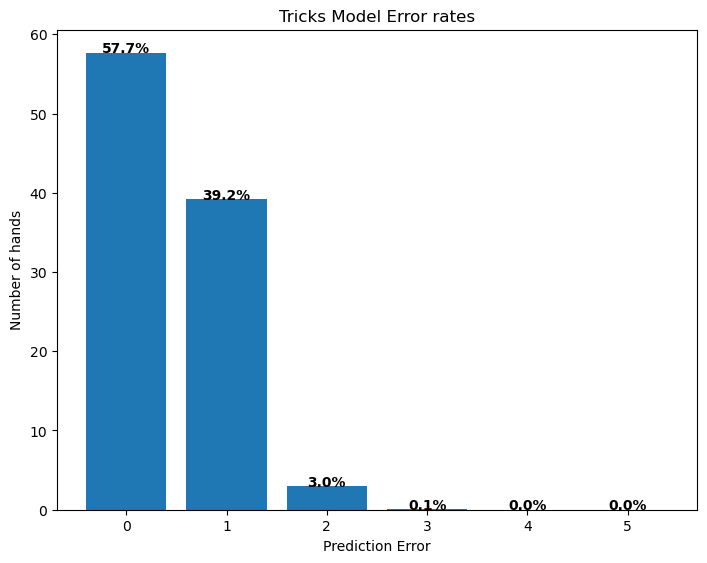

In [28]:
plot_trick_error_rates(targets_list = test_targets_df, 
                       preds_list=test_preds_rounded)

In [29]:
def print_pred_eval_kpis(y_true, y_pred):
    """
    Prints model evaluation kpis
    """
    
    import numpy as np
    from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error
    from sklearn.metrics import r2_score, explained_variance_score
    from sklearn.metrics import precision_score, recall_score, f1_score
    from sklearn.metrics import roc_curve, roc_auc_score, log_loss

    # Assuming y_true contains actual target values and y_pred contains predicted values

    # Regression Metrics
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    explained_var = explained_variance_score(y_true, y_pred)

    # Print or display the calculated metrics
    print("Regression Metrics:")
    print(f"MSE: {mse}")
    print(f"MAE: {mae}")
    print(f"Median Absolute Error: {medae}")
    print(f"R-squared: {r2}")
    print(f"Explained Variance: {explained_var}")

In [30]:
print_pred_eval_kpis(y_true=test_targets_df, y_pred=test_preds)

Regression Metrics:
MSE: 0.43502113505587403
MAE: 0.5135173244295932
Median Absolute Error: 0.41842079162597656
R-squared: 0.6431537275202357
Explained Variance: 0.6431619811654048


In [31]:
print_pred_eval_kpis(y_true=test_targets_df, y_pred=test_preds_rounded)

Regression Metrics:
MSE: 0.5224091587854655
MAE: 0.45527127924340466
Median Absolute Error: 0.0
R-squared: 0.5714696459565374
Explained Variance: 0.5714790438119552


In [32]:
valid_preds_linreg = reg.predict(valid_df)

In [33]:
valid_preds_linreg_rounded = [round(pred) for pred in valid_preds_linreg]

In [34]:
print_pred_eval_kpis(y_true=valid_targets_df, y_pred=valid_preds_linreg)

Regression Metrics:
MSE: 0.42918514133996577
MAE: 0.5105065343599566
Median Absolute Error: 0.41528987884521484
R-squared: 0.6464541090771299
Explained Variance: 0.6464592281082785


In [35]:
print_pred_eval_kpis(y_true=valid_targets_df, y_pred=valid_preds_linreg_rounded)

Regression Metrics:
MSE: 0.5167144506829132
MAE: 0.4517879186078923
Median Absolute Error: 0.0
R-squared: 0.5743508960979946
Explained Variance: 0.5743672077890146


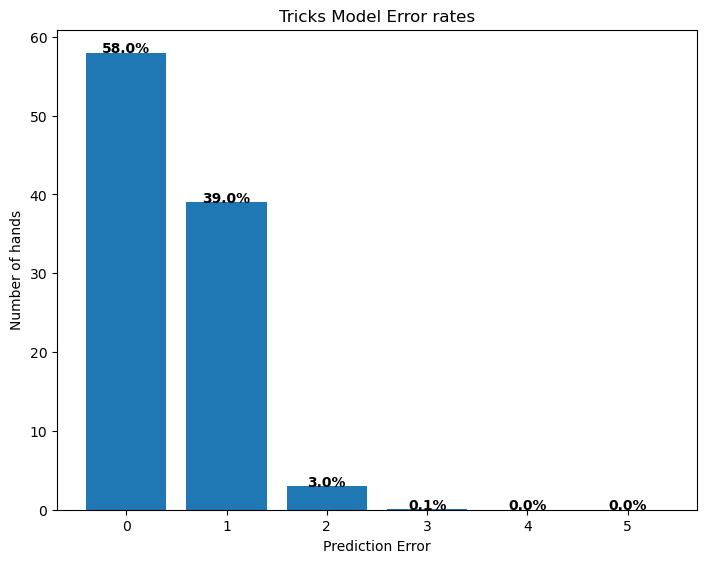

In [36]:
plot_trick_error_rates(targets_list = valid_targets_df, 
                       preds_list=valid_preds_linreg_rounded)

#### Test single hand manually

In [37]:
hand = {feature:[0] for feature in model_features}
single_hand_test_df = pd.DataFrame(hand)
single_hand_test_df

,has_right,has_left,has_Atrump,has_Ktrump,has_Qtrump,has_Ttrump,has_9trump,num_off_A,num_off_K,num_off_Q,num_suits,player_seat1,player_seat2,player_seat3,player_seat4
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [38]:
single_hand_test_df['player_seat1'] = 0
single_hand_test_df['player_seat2'] = 1
single_hand_test_df['player_seat3'] = 0
single_hand_test_df['player_seat4'] = 0
single_hand_test_df['num_suits'] = 3
single_hand_test_df['has_right'] = 0
single_hand_test_df['has_left'] = 0
single_hand_test_df['has_Atrump'] = 0
single_hand_test_df['has_Ktrump'] = 1
single_hand_test_df['has_Qtrump'] = 1
single_hand_test_df['has_Ttrump'] = 1
single_hand_test_df['has_9trump'] = 0
single_hand_test_df['num_off_Q'] = 2
single_hand_test_df['num_off_K'] = 0
single_hand_test_df['num_off_A'] = 0

In [39]:
single_test_pred = reg.predict(single_hand_test_df)
single_test_pred

array([1.58013916])

### Regularized linear regression

#### Ridge

In [40]:
from sklearn.linear_model import Ridge

In [41]:
ridge = Ridge(alpha=0.8).fit(train_df, train_targets_df)

In [42]:
ridge.score(test_df, test_targets_df)

0.6431616824229147

In [43]:
# ridge.coef_
for coef in range(len(ridge.coef_)):
    print(f'{train_df.columns[coef]}: {ridge.coef_[coef]}')

has_right: 1.3293650194326614
has_left: 0.9362174904596473
has_Atrump: 0.8575177330003979
has_Ktrump: 0.6733625553911
has_Qtrump: 0.5443869264734927
has_Ttrump: 0.4518037937064133
has_9trump: 0.3669167862451014
num_off_A: 0.3432865989924619
num_off_K: 0.0800299220255729
num_off_Q: 0.017855677274791766
num_suits: -0.20963938283341133
player_seat1: 0.0006426878132928575
player_seat2: -0.011169638111233246
player_seat3: 0.017163343751393355
player_seat4: -0.006636390912945853


In [44]:
test_preds = ridge.predict(test_df)
test_preds[0:5]

array([2.29516574, 2.0530305 , 1.59074941, 1.09829211, 0.42614703])

In [45]:
test_preds_rounded = [round(pred) for pred in test_preds]
test_preds_rounded[0:5]

[2, 2, 2, 1, 0]

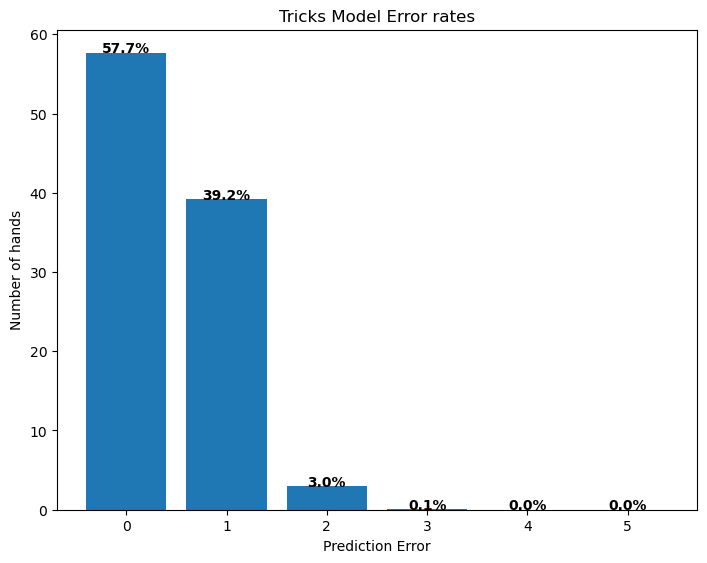

In [46]:
plot_trick_error_rates(targets_list = test_targets_df, 
                       preds_list=test_preds_rounded)

In [47]:
print_pred_eval_kpis(y_true=test_targets_df, y_pred=test_preds)

Regression Metrics:
MSE: 0.4350114374604119
MAE: 0.5135075101524474
Median Absolute Error: 0.4189413057963516
R-squared: 0.6431616824229147
Explained Variance: 0.6431699888328739


#### Lasso

In [48]:
from sklearn.linear_model import Lasso

In [49]:
lasso = Lasso(alpha=0.01).fit(train_df, train_targets_df)

In [50]:
sum(lasso.coef_ != 0)

11

In [51]:
# lasso.coef_
for coef in range(len(lasso.coef_)):
    print(f'{train_df.columns[coef]}: {lasso.coef_[coef]}')

has_right: 1.2448425045906633
has_left: 0.8178899749010057
has_Atrump: 0.7742880134377824
has_Ktrump: 0.5895533950982215
has_Qtrump: 0.4607350833519382
has_Ttrump: 0.3682890096563342
has_9trump: 0.2827604364885708
num_off_A: 0.26554104836497894
num_off_K: 0.0020990282826310962
num_off_Q: -0.021178577232590607
num_suits: -0.21099707379435662
player_seat1: 0.0
player_seat2: -0.0
player_seat3: 0.0
player_seat4: -0.0


In [52]:
test_preds = lasso.predict(test_df)
test_preds[0:5]

array([2.23227824, 2.03805265, 1.64858506, 1.02782779, 0.39072122])

In [53]:
test_preds_rounded = [round(pred) for pred in test_preds]
test_preds_rounded[0:5]

[2, 2, 2, 1, 0]

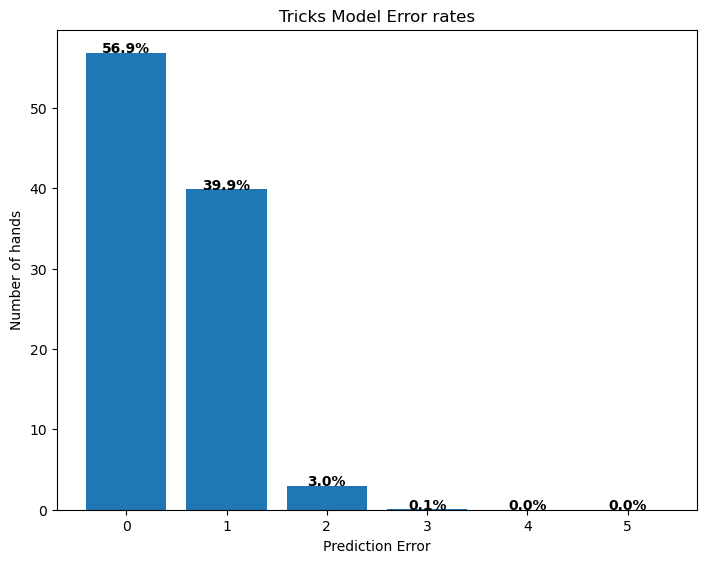

In [54]:
plot_trick_error_rates(targets_list = test_targets_df, 
                       preds_list=test_preds_rounded)

In [55]:
print_pred_eval_kpis(y_true=test_targets_df, y_pred=test_preds)

Regression Metrics:
MSE: 0.4428156007644707
MAE: 0.5251447236796721
Median Absolute Error: 0.4215593087095564
R-squared: 0.6367599553332204
Explained Variance: 0.6367708192256091


In [56]:
#### ElasticNet
# from sklearn.linear_model import ElasticNet
# elastic_net = ElasticNet(alpha=0.01, l1_ratio=0.01).fit(train_df, train_targets_df)
# elastic_net.score(test_df, test_targets_df)

#### Random Forest

In [57]:
from sklearn.ensemble import RandomForestClassifier

In [58]:
classifier =  RandomForestClassifier(
    n_estimators=100, 
    max_features=0.9,
    max_depth=8,
    min_samples_split=2,
    min_samples_leaf=1,
    criterion = 'entropy', 
    verbose=0
)

In [59]:
%%time

classifier.fit(train_df, train_targets_df)  # Fit the model

CPU times: user 16.1 s, sys: 291 ms, total: 16.4 s
Wall time: 16.4 s


RandomForestClassifier(criterion='entropy', max_depth=8, max_features=0.9)

In [60]:
test_preds = classifier.predict(test_df)
# test_preds = classifier.predict_proba(test_df)
test_preds[0:3]

array([2, 2, 1])

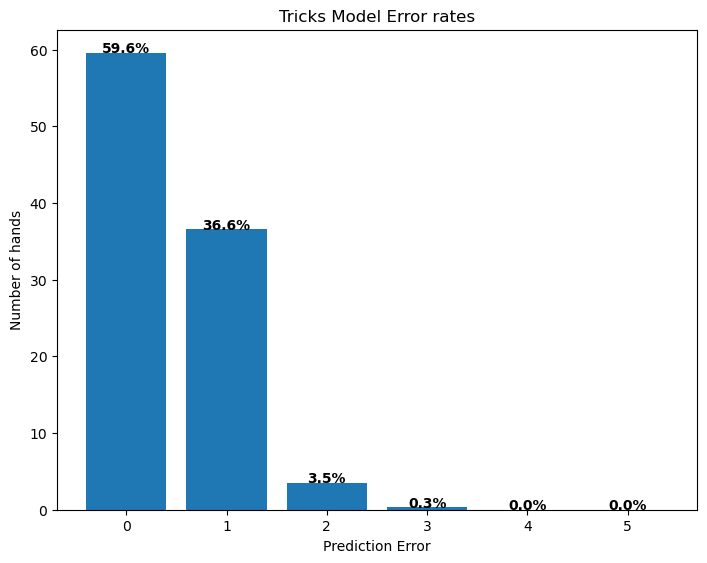

In [61]:
plot_trick_error_rates(targets_list = test_targets_df, 
                       preds_list=test_preds)

In [62]:
print_pred_eval_kpis(y_true=test_targets_df, y_pred=test_preds)

Regression Metrics:
MSE: 0.5359482329517172
MAE: 0.4456744649079144
Median Absolute Error: 0.0
R-squared: 0.5603635921128926
Explained Variance: 0.5762794670585847


In [63]:
single_hand_preds = classifier.predict_proba(single_hand_test_df)
single_hand_preds

array([[8.19699472e-02, 4.74741639e-01, 3.51638800e-01, 8.59758205e-02,
        5.59365038e-03, 8.01428923e-05]])

In [64]:
importances = classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in classifier.estimators_], axis=0)

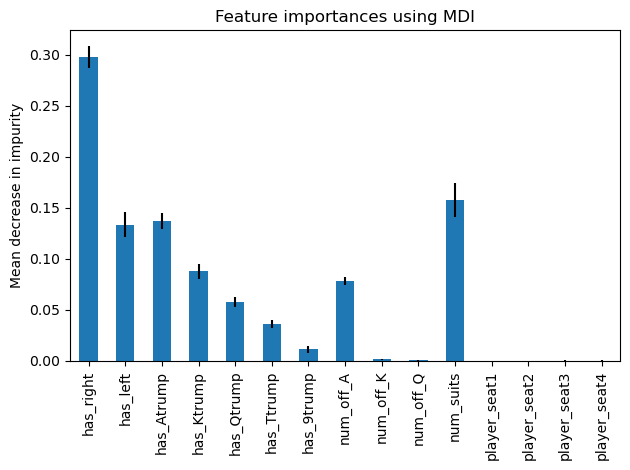

In [65]:
forest_importances = pd.Series(importances, index=model_features)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### GBM

In [66]:
from sklearn.ensemble import GradientBoostingClassifier

In [67]:
gbm_clf = GradientBoostingClassifier(learning_rate=0.1, 
                                     n_estimators=10, 
                                     #subsample=0.9, 
                                     #max_depth=6
                                    )

#### Fit the model

In [68]:
%%time

gbm_clf.fit(train_df, train_targets_df)

CPU times: user 8.65 s, sys: 368 ms, total: 9.01 s
Wall time: 8.63 s


GradientBoostingClassifier(n_estimators=10)

In [69]:
# Create test preds
test_preds = gbm_clf.predict(test_df)
#test_preds = gbm_clf.predict_proba(test_df)
test_preds[0:3]

array([1, 2, 2])

In [70]:
single_hand_preds = gbm_clf.predict_proba(single_hand_test_df)
single_hand_preds

array([[0.27450522, 0.36255804, 0.25092522, 0.09189939, 0.01888124,
        0.00123089]])

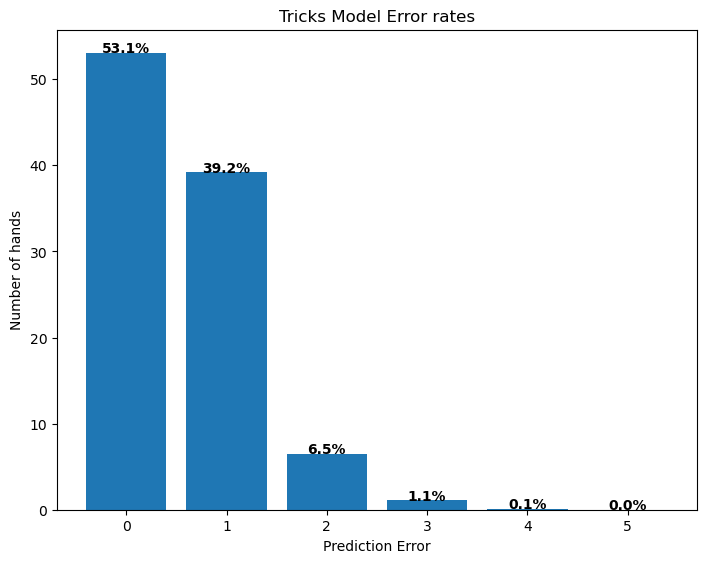

In [71]:
plot_trick_error_rates(targets_list = test_targets_df, 
                       preds_list=test_preds)

In [72]:
print_pred_eval_kpis(y_true=test_targets_df, y_pred=test_preds)

Regression Metrics:
MSE: 0.7690393230462916
MAE: 0.5591040318566451
Median Absolute Error: 0.0
R-squared: 0.3691598092488474
Explained Variance: 0.458067496890861


In [73]:
valid_preds = gbm_clf.predict(valid_df)
valid_preds_rounded = [round(pred) for pred in valid_preds]

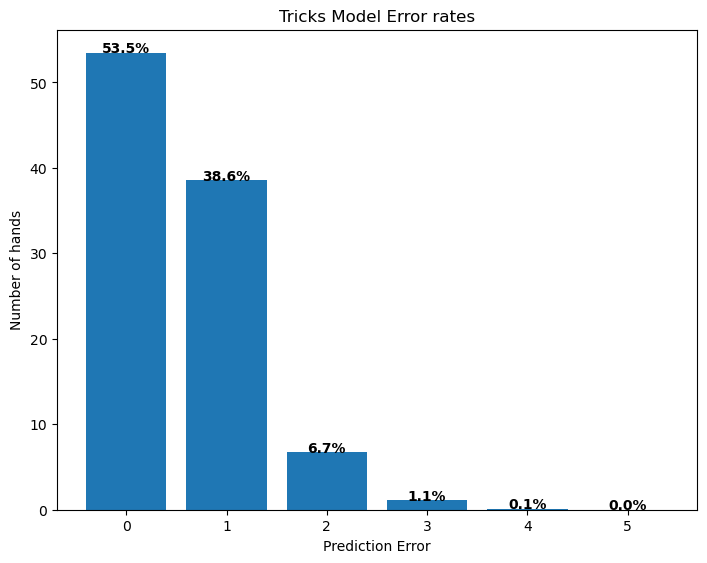

In [74]:
plot_trick_error_rates(targets_list = valid_targets_df, 
                       preds_list=valid_preds_rounded)

In [75]:
importances = gbm_clf.feature_importances_

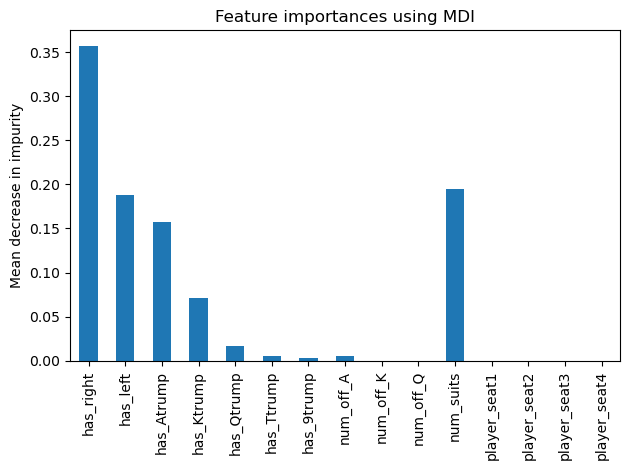

In [76]:
forest_importances = pd.Series(importances, index=model_features)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### xgboost

In [21]:
import xgboost as xgb

In [22]:
from sklearn.metrics import mean_squared_error

In [23]:
# Create XGBoost DMatrix objects for efficient training
dtrain = xgb.DMatrix(train_df, label=train_targets_df)
dtest = xgb.DMatrix(test_df, label=test_targets_df)

In [24]:
# Define XGBoost parameters
params = {
    'objective': 'reg:squarederror',  # Use regression objective for predicting number of tricks
    'eval_metric': 'rmse',  # Root Mean Squared Error as evaluation metric
    'max_depth': 3,  # Maximum depth of each tree
    'learning_rate': 0.1,  # Learning rate (eta) to prevent overfitting
    # 'n_estimators': 100  # Number of boosting rounds (trees) to build
}

In [25]:
# model = xgb.train(params, dtrain, num_boost_round=params['n_estimators'])
model = xgb.train(params=params, dtrain=dtrain, num_boost_round=100)

In [26]:
# Make predictions on the test set
predictions = model.predict(dtest)

In [27]:
# sk-learn API

# xgb_reg = xgb.XGBRegressor(params, objective='reg:squarederror')
# xgb_reg.fit(X=train_df, y=train_targets_df)
# predictions = xgb_reg.predict(test_df)

In [28]:
predictions[0:5]

array([2.278387  , 1.9994563 , 1.6226538 , 0.75108445, 0.37350795],
      dtype=float32)

In [29]:
# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(test_targets_df, predictions))
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 0.654395523399493


In [32]:
# print_pred_eval_kpis(y_true=test_targets_df, y_pred=predictions)

In [33]:
predictions_rounded = [round(pred) for pred in predictions]

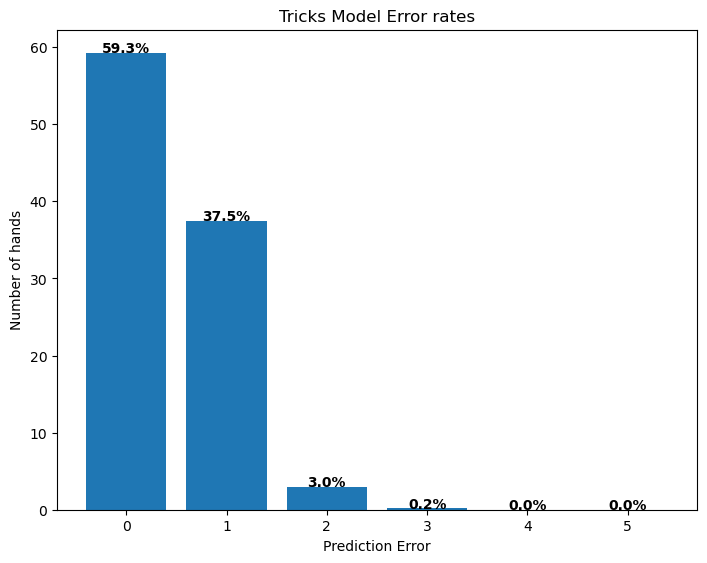

In [38]:
plot_trick_error_rates(targets_list = test_targets_df, 
                       preds_list=predictions_rounded)

In [101]:
from sklearn.model_selection import cross_val_score, KFold

In [102]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

In [104]:
# Perform cross-validation
scores = cross_val_score(xgb.XGBRegressor(**params), train_df, train_targets_df, scoring='neg_mean_squared_error', cv=kf)

# Print the mean RMSE across folds
print("Mean RMSE:", np.sqrt(-scores.mean()))

Mean RMSE: 0.6498912590865986


In [105]:
scores

array([-0.41940286, -0.42429374, -0.42210991, -0.42592683, -0.4200599 ])

In [106]:
from sklearn.model_selection import GridSearchCV

In [112]:
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror')

In [125]:
param_grid = {
    'max_depth': [4, 5, 6],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200],
}

In [126]:
%%time

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(train_df, train_targets_df)

CPU times: user 4min 9s, sys: 2min 33s, total: 6min 42s
Wall time: 42.4 s


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.01], 'max_depth': [4, 5, 6],
                         'n_estimators': [100, 200]},
             scoring='neg_mean_squared_error')

In [127]:
# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = np.sqrt(-grid_search.best_score_)

print("Best Parameters:", best_params)
print("Best RMSE:", best_score)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best RMSE: 0.6421784317246743


In [128]:
# Evaluate the model with the best parameters on the test set
best_model = grid_search.best_estimator_
predictions = best_model.predict(test_df[train_df.columns])
test_rmse = np.sqrt(mean_squared_error(test_targets_df, predictions))
print("Test RMSE with Best Parameters:", test_rmse)

Test RMSE with Best Parameters: 0.6462751043667155


In [37]:
plot_trick_error_rates(targets_list = test_targets_df, 
                       preds_list=predictions)

KeyError: '0.27838706970214844'

### Look at worst predictions

In [39]:
# add targets to test_df
test_df.loc[:,'actual'] = test_targets_df

In [40]:
# add preds to test_df
test_df.loc[:,'preds'] = test_preds

NameError: name 'test_preds' is not defined

In [41]:
test_df.loc[:,'pred_err'] = abs(test_targets_df - test_preds)

NameError: name 'test_preds' is not defined

In [42]:
test_df.sort_values('pred_err', ascending=False).head(10)

KeyError: 'pred_err'

### Cross Validation

In [139]:
from sklearn.model_selection import GridSearchCV

In [140]:
grid_params = {'n_estimators':[10], 'max_depth':[4,5], 'learning_rate':[0.1] ,'subsample':[0.9]}

In [141]:
clf = GridSearchCV(gbm_clf, grid_params)

In [142]:
%%time

clf.fit(train_df, train_targets_df)

Wall time: 5min 22s


GridSearchCV(estimator=GradientBoostingClassifier(n_estimators=10),
             param_grid={'learning_rate': [0.1], 'max_depth': [4, 5],
                         'n_estimators': [10], 'subsample': [0.9]})

In [143]:
clf.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_learning_rate', 'param_max_depth', 'param_n_estimators', 'param_subsample', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [144]:
clf.cv_results_

{'mean_fit_time': array([24.12750382, 31.91451254]),
 'std_fit_time': array([0.34865573, 1.76299289]),
 'mean_score_time': array([0.15954123, 0.2064991 ]),
 'std_score_time': array([0.00291815, 0.02637562]),
 'param_learning_rate': masked_array(data=[0.1, 0.1],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[4, 5],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[10, 10],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_subsample': masked_array(data=[0.9, 0.9],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'learning_rate': 0.1,
   'max_depth': 4,
   'n_estimators': 10,
   'subsample': 0.9},
  {'learning_rate': 0.1,
   'max_depth': 5,
   'n_estimators': 10,
   'subsample': 0.9}],
 'split0_test_score': array([0.55610494, 0.56972476]),

In [145]:
clf.best_estimator_

GradientBoostingClassifier(max_depth=5, n_estimators=10, subsample=0.9)

In [ ]:
clf.best_estimator_.predict_proba(single_hand_test_df)

In [ ]:
single_hand_preds = clf.predict_proba(single_hand_test_df)
single_hand_preds

In [ ]:
test_preds = clf.best_estimator_.predict(test_df)

In [ ]:
importances = clf.best_estimator_.feature_importances_

In [ ]:
forest_importances = pd.Series(importances, index=model_features)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### Save out model to disk using joblib

In [ ]:
import joblib

In [ ]:
pwd

In [ ]:
joblib.dump(classifier, 'C:/Users/jerem/Desktop/nonsense/euchre/models/trick_model_rf_v0.sav')

#### Plot probability output

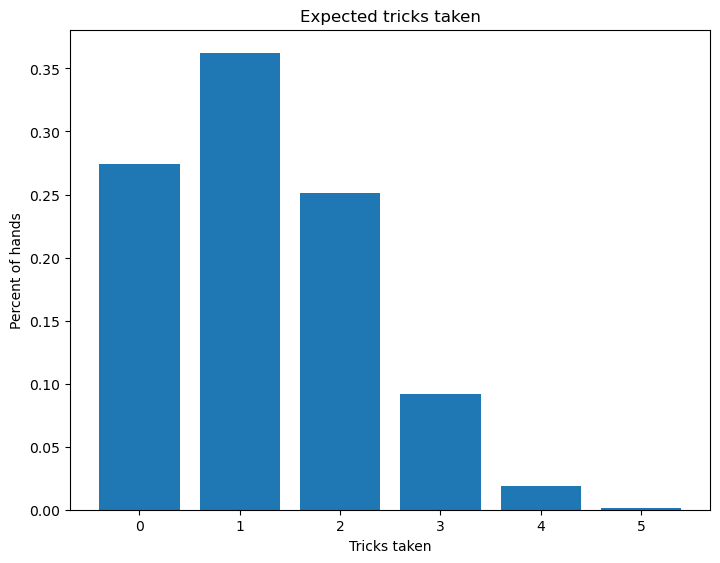

In [80]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
num_tricks_taken = ['0','1','2','3','4','5']
ax.bar(num_tricks_taken, single_hand_preds.tolist()[0])

plt.xlabel("Tricks taken")
plt.ylabel("Percent of hands")
plt.title("Expected tricks taken")

# ax.bar_label(trick_preds, label_type='center')

plt.show()

In [81]:
trick_preds = single_hand_preds.tolist()[0]
trick_preds

[0.2745052220779479,
 0.3625580443784761,
 0.25092521709556115,
 0.09189938920396291,
 0.018881240270212964,
 0.0012308869738389672]

In [83]:
# plot_expected_tricks_taken(expected_tricks_taken = trick_preds)

#### Breakdown of percent of hands predicted correctly, 1 off, 2 off, etc.

In [84]:
results_dict = {str(num): 0 for num in range(0,6)}

#for idx, pred in enumerate(test_targets_df[0:100]):
for idx, pred in enumerate(test_targets_df):
    pred_diff = abs(pred - test_preds[idx])
    results_dict[str(pred_diff)] += 1

results_dict
# list(results_dict.values())

{'0': 26685, '1': 19666, '2': 3271, '3': 539, '4': 64, '5': 0}

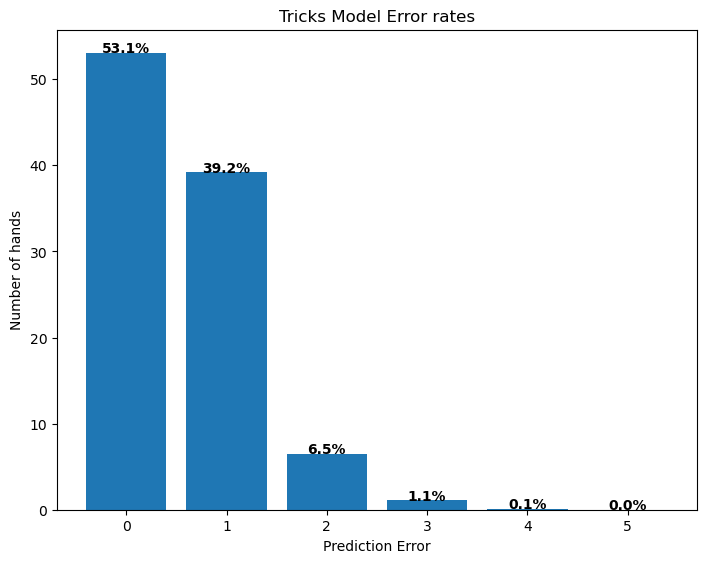

In [85]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
num_tricks_taken = ['0','1','2','3','4','5']
percents = [round(100.0*x / sum(results_dict.values()),1) for x in results_dict.values()]
graph = ax.bar(num_tricks_taken, percents)

i = 0
for p in graph:
    width = p.get_width()
    height = p.get_height()
    x,y = p.get_xy()
    plt.text(x+width/2,
             y+height*1,
             str(percents[i])+'%',
             ha='center',
             weight='bold')
    i += 1

plt.xlabel("Prediction Error")
plt.ylabel("Number of hands")
plt.title("Tricks Model Error rates")

plt.show()

#### Pipeline

In [86]:
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import OneHotEncoder

## Next Steps

In [ ]:
# Build separate model for team tricks won

# Standardize input features to linear model
# Cross-validate tree-based models - RF, GBM, etc.
# sklearn pipeline

# PyTorch models
    # compare PyTorch version vs. sklearn
# Classification models to predict likelihood for each score outcome

# EUCHRE questions to answer:
# Is it possible to take a trick with an off-suit Jack, that wouldn't have been taken with the 10 or 9 ???

# Is there ever a time when knowing the current score of the game should affect which card to play?
    # If opponent has 9 points, play more aggressively?

# Is there ever a time when knowing the current number of tricks taken should affect which card to play?
    # If opponents have taken 2 tricks already, play more aggressively?   

### Write out all hand results to csv local

In [ ]:
pwd

In [ ]:
all_hand_results_df = pd.read_csv('all_hand_results.csv')

In [ ]:
all_hand_results_df.shape

In [ ]:
hand_results_40k_df = all_hand_results_df.head(40000)
hand_results_40k_df.shape

In [ ]:
hand_results_40k_df.to_csv('hand_results_40k.csv', index=False)